In [1]:
from datasets import Dataset, load_dataset, features, ClassLabel, load_from_disk

import pandas as pd
import numpy as np
import scipy.stats as stats
import researchpy as rp
from itertools import chain

import networkx as nx
import community as community_louvain
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms import bipartite

import seaborn as sns
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.feature_selection import mutual_info_classif
# from sklearn.ensemble import RandomForestClassifier
# from sklearn import svm
# from sklearn.neural_network import MLPClassifier
# from sklearn.linear_model import RidgeClassifier

from llm_mri import LLM_MRI

/home/figenio/Projetos/data_science/experimentacao/graph_experimenting/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carregando os dados e dividindo classes

Top quantil: 6.0
Botton quantil: 4.0
All columns ['annotation id', 'original', 'traducao', 'organization level', 'global score', 'auto', 'label']
top: 88
botton: 104
TOTAL: 435


text   label
0  A doença pulmonar obstrutiva crônica afeta a r...  botton
1  A doença pulmonar obstrutiva crônica dificulta...  botton
2  A doença obstrutiav pulomonar esta relacionada...     mid
3  A doença pulmonar obstrutiva crônica ou DPOC o...  botton
4  DPOC reduz fluxo aéreo, perda da elastância, a...  botton

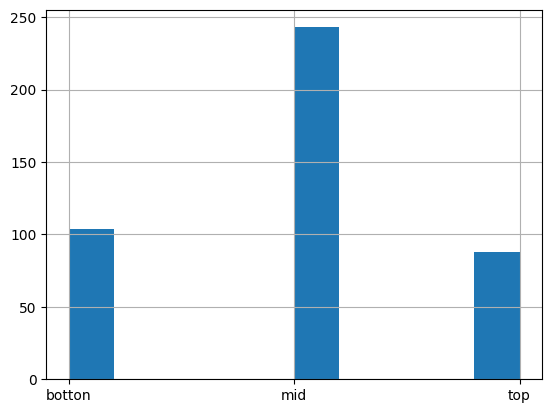

In [2]:
def label_answer(row, score, botton_quantile, top_quantile):
    if (row[score] < botton_quantile):
        return 'botton'
    elif (row[score] > top_quantile):
        return 'top'
    else:
        return 'mid'

# exp = "_iam"
exp = "_dpoc"

df_traducao = pd.read_csv('data/experimento_consolidado' + exp + '.csv')

score = 'global score'
# score = 'organization level'
quantile = .3
# map_dimension = 5
map_dimension = 10
# map_dimension = 25

# model_ckpt = "distilbert-base-uncased"          # 67M
# model_ckpt = "bert-base-uncased"                # 110M
# model_ckpt = "emilyalsentzer/Bio_ClinicalBERT"
# model_ckpt = "google-bert/bert-large-uncased"   # 336M
# model_ckpt = "bvanaken/clinical-assertion-negation-bert"
# model_ckpt = "gpt2"
# model_ckpt = 'openai-community/gpt2'
# model_ckpt = "openai-community/gpt2-large"
# model_ckpt = "FacebookAI/xlm-roberta-large"     # 560M
# model_ckpt = "facebook/xlm-roberta-xl"          # 3.48B
# model_ckpt = "facebook/xlm-roberta-xxl"         # 10.7B
# model_ckpt = "meta-llama/Meta-Llama-3-8B"
# model_ckpt = "unsloth/Meta-Llama-3.1-8B"

# model_ckpt = "pucpr/gpt2-bio-pt"
# model_ckpt = "pierreguillou/gpt2-small-portuguese"
# model_ckpt = "neuralmind/bert-base-portuguese-cased"
model_ckpt = "google-bert/bert-base-multilingual-cased"
# model_ckpt = "pucpr/biobertpt-all"

model_layers_size = 12



# LABELING POR QUANTILE
print("Top quantil:", df_traducao[score].quantile(1 - quantile))
print("Botton quantil:", df_traducao[score].quantile(quantile))
df_traducao['label'] = df_traducao.apply(
    label_answer,
    axis=1,
    score=score,
    botton_quantile=df_traducao[score].quantile(quantile),
    top_quantile=df_traducao[score].quantile(1 - quantile),
)

# LABELING ALEATÓRIO BALANCEADO
# df_traducao = df_traducao.sample(frac=1, random_state=42)
# print("Top quantil:", df_traducao.nlargest(round(len(df_traducao) * quantile), columns=[score]).iloc[-1:][score])
# print("Botton quantil:", df_traducao.nsmallest(round(len(df_traducao) * quantile), columns=[score]).iloc[-1:][score])
# top_indexes = list(df_traducao.nlargest(round(len(df_traducao) * quantile), columns=[score]).index)
# botton_indexes = list(df_traducao.nsmallest(round(len(df_traducao) * quantile), columns=[score]).index)
# df_traducao.loc[top_indexes, "label"] = "top"
# df_traducao.loc[botton_indexes, "label"] = "botton"
# df_traducao = df_traducao.fillna("mid")


columns_to_remove = list(df_traducao.columns)
print("All columns", columns_to_remove)
columns_to_remove.remove('original')
columns_to_remove.remove('label')

df_data = df_traducao.rename(columns={'original': 'text'}).drop(columns=columns_to_remove).reset_index(drop=True)

df_data['label'].hist()
print("top:", df_data['label'].loc[df_data['label'] == "top"].count())
print("botton:", df_data['label'].loc[df_data['label'] == "botton"].count())
print("TOTAL:", df_data['label'].count())
df_data.head()

In [3]:
from transformers import AutoTokenizer, AutoModel

import warnings
warnings.filterwarnings('ignore')

model = AutoModel.from_pretrained(model_ckpt)

model.config

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

BertConfig {
  "_name_or_path": "google-bert/bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}

In [4]:
# Se a diferença entre classes for grande, recorta

# diff = abs(df_data['label'].loc[df_data['label'] == "top"].count() - df_data['label'].loc[df_data['label'] == "botton"].count())
# print("diff:", diff)
# df_data = df_data.sort_values(by='label', ascending=False).iloc[diff:].reset_index(drop=True)

# df_data

# Passando os Dados para o Módulo

- converte o Dataframe para Dataset;
- carrega o modelo e os dados no módulo;
- processa as ativações;

In [5]:
subset = Dataset.from_pandas(df_data)
subset.cleanup_cache_files()

label_feature = subset.features['label']
class_names  = subset.unique("label")

class_feature = features.ClassLabel(names=sorted(class_names))
subset = subset.map(lambda str_value: {"label": class_feature.str2int(str_value)}, input_columns="label")

subset = subset.cast(features.Features({
    "label": class_feature,
    "text": subset.features["text"]}))

Casting the dataset: 100%|█████████| 435/435 [00:00<00:00, 160864.24 examples/s]


In [6]:
llm_mri = LLM_MRI(model=model_ckpt, device="cpu", dataset=subset)

llm_mri.process_activation_areas(map_dimension = map_dimension)

Map:   0%|                                       | 0/435 [00:00<?, ? examples/s]A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A

# Visualizando as Ativações

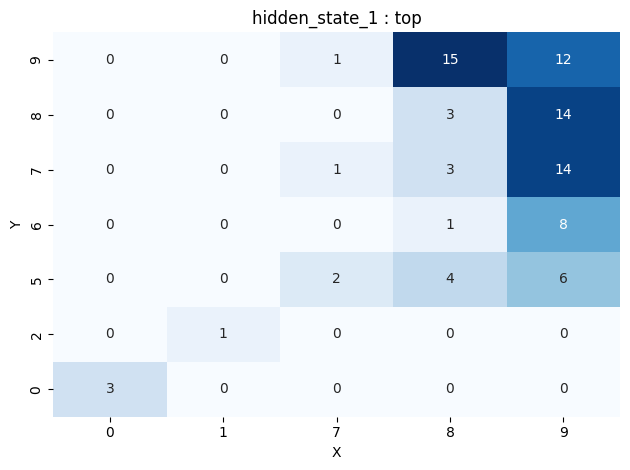

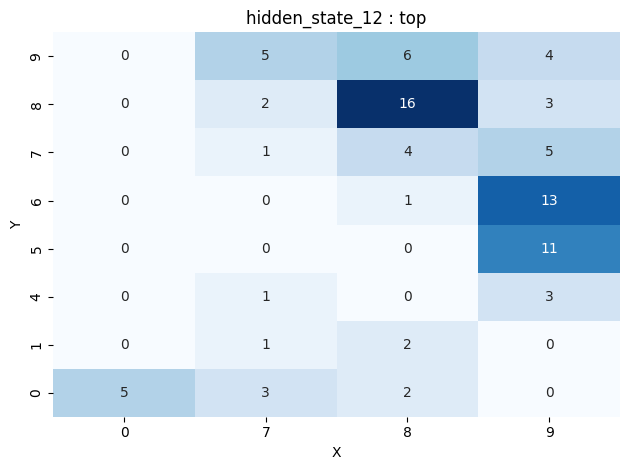

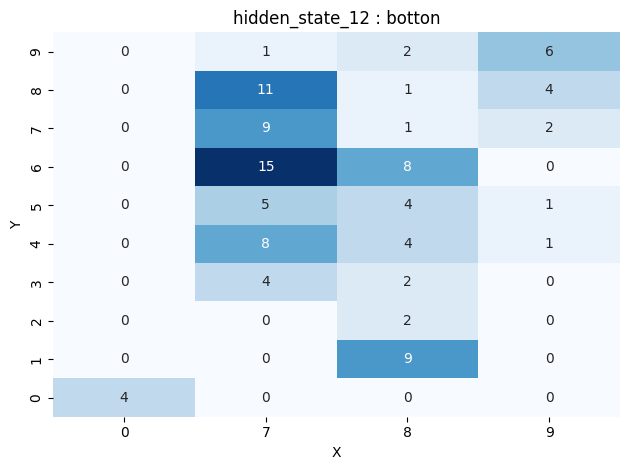

In [7]:
fig = llm_mri.get_layer_image(layer=1, category="top")
#plt.figure(figsize=(30,30))
plt.tight_layout()

plt.savefig('images/hidden_state/top1' + exp + '.png')
plt.show()

fig = llm_mri.get_layer_image(layer=model_layers_size, category="top")
#plt.figure(figsize=(30,30))
plt.tight_layout()

plt.savefig('images/hidden_state/top12' + exp + '.png')
plt.show()

fig = llm_mri.get_layer_image(layer=model_layers_size, category="botton")
plt.tight_layout()

plt.savefig('images/hidden_state/botton12' + exp + '.png')
plt.show()

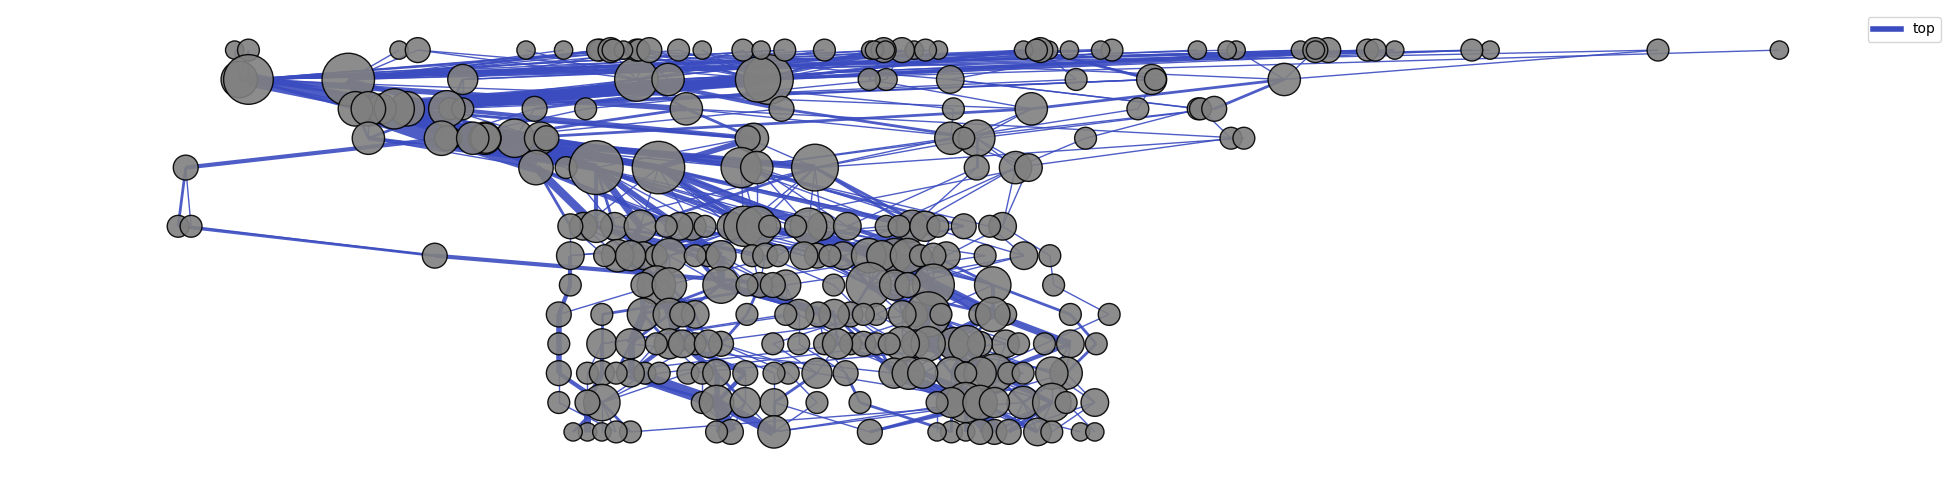

In [8]:
G_top = llm_mri.get_graph("top")

for n in G_top.nodes:
    G_top.nodes[n]['layer'] = int(n.split("_")[0])

g_img = llm_mri.get_graph_image(G_top)
plt.box(False)
plt.savefig('images/graph/top_' + model_ckpt.split('/')[1] + exp + '.png')
plt.show()

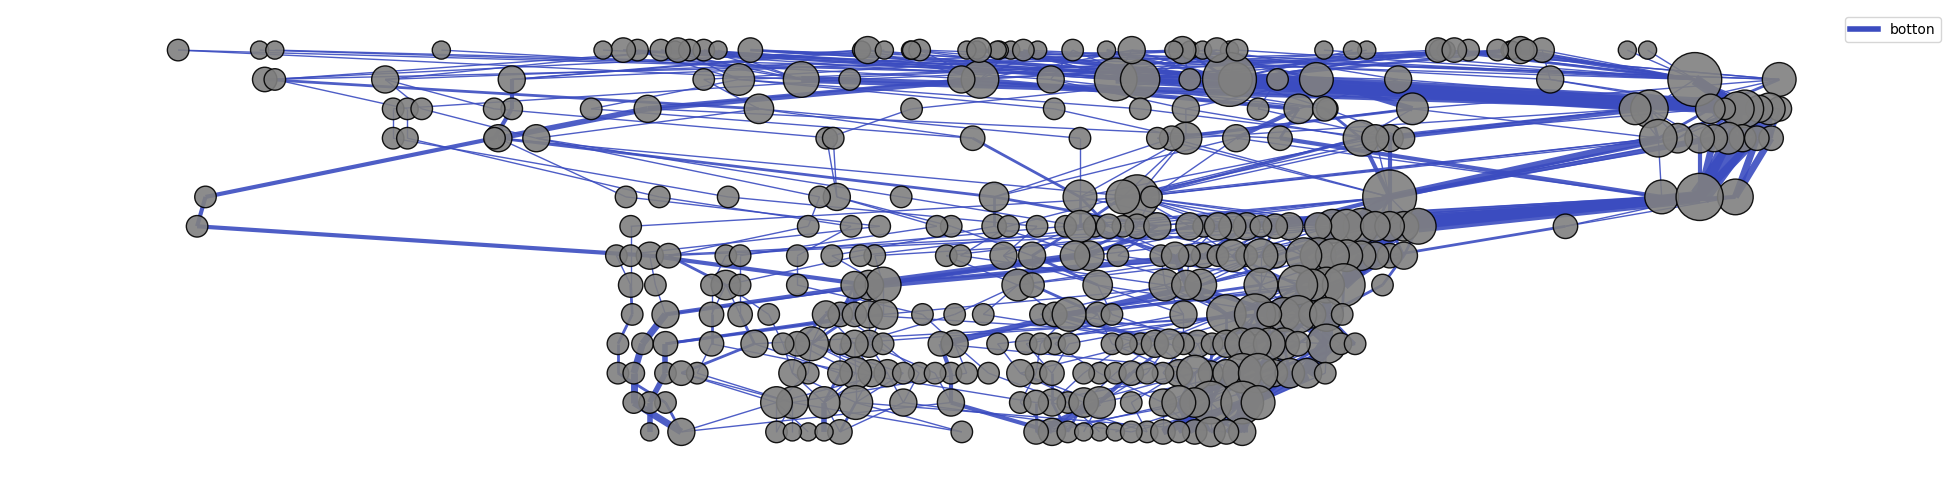

In [9]:
G_botton = llm_mri.get_graph("botton")

for n in G_botton.nodes:
    G_botton.nodes[n]['layer'] = int(n.split("_")[0])

g_img = llm_mri.get_graph_image(G_botton)
plt.box(False)
plt.savefig('images/graph/botton_' + model_ckpt.split('/')[1] + exp + '.png')
plt.show()

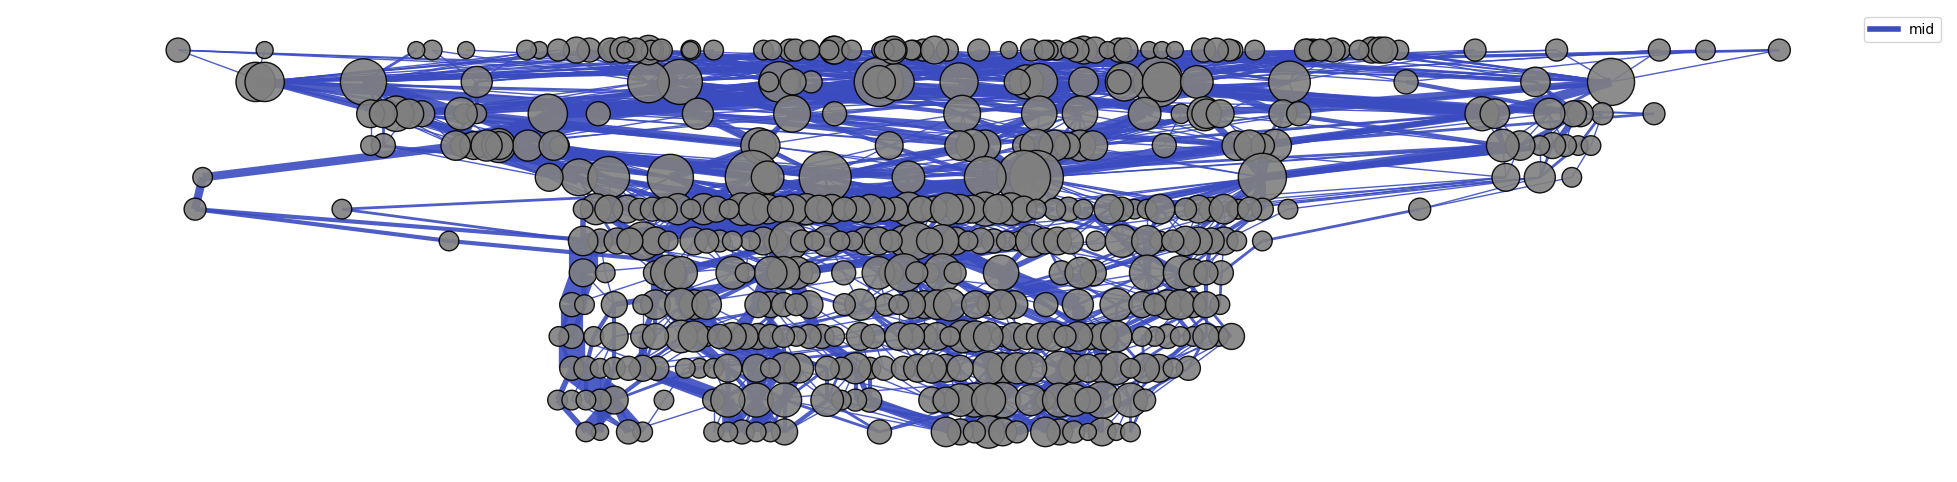

In [10]:
G_mid = llm_mri.get_graph("mid")

for n in G_mid.nodes:
    G_mid.nodes[n]['layer'] = int(n.split("_")[0])

g_img = llm_mri.get_graph_image(G_mid)
plt.box(False)
plt.show()

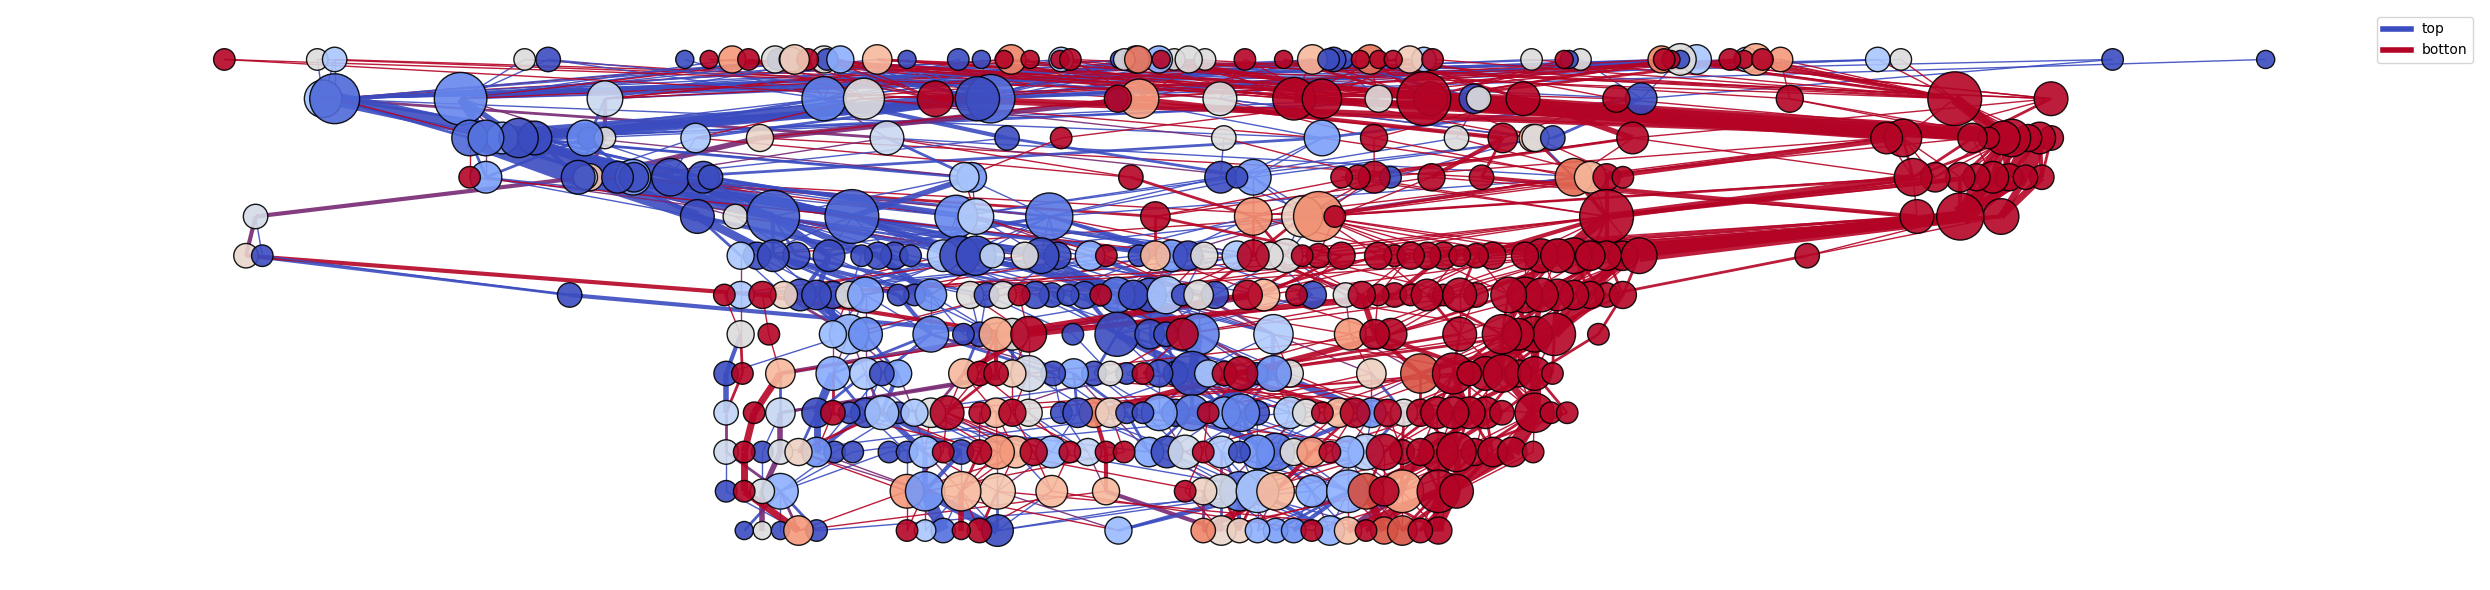

In [11]:
G_composed = llm_mri.get_composed_graph("top", "botton")
G_composed_img = llm_mri.get_graph_image(G_composed)

for n in G_composed.nodes:
    G_composed.nodes[n]['layer'] = int(n.split("_")[0])

plt.box(False)
plt.tight_layout()
plt.savefig('images/graph/both_' + model_ckpt.split('/')[1] + exp + '.png')
plt.show()

# nx.write_gml(G_top, 'graphs/top_' + model_ckpt.split('/')[1] + exp + '.gml')
# nx.write_gml(G_botton, 'graphs/botton_' + model_ckpt.split('/')[1] + exp + '.gml')


label1, label2 = [0, 1]

label1_counts = {node: 0 for node in G_composed.nodes()}
label2_counts = {node: 0 for node in G_composed.nodes()}

for u, v, data in G_composed.edges(data=True):
    label = data.get('label')
    weight = data.get('weight', 1)  # default weight is 1 if not specified

    if label == label1:
        label1_counts[u] += weight
        label1_counts[v] += weight

    elif label == label2:
        label2_counts[u] += weight
        label2_counts[v] += weight
    
    else: # label == 2

        label1_counts[u] += weight
        label1_counts[v] += weight
        label2_counts[u] += weight
        label2_counts[v] += weight


# initialize Normalize object to map ratios between 0 and 1
norm = plt.Normalize(vmin=0, vmax=1)

# compute proportions and assign node colors
node_colors = []
for node in G_composed.nodes():
    count_label1 = label1_counts.get(node, 0)
    count_label2 = label2_counts.get(node, 0)
    total = count_label1 + count_label2

    if total > 0:
        ratio = count_label2 / total  # proportion of label2
    else:
        ratio = 0.5  # neutral ratio if no connected edges

    # normalize the ratio
    norm_ratio = norm(ratio)
    node_colors.append(norm_ratio)

    G_composed.nodes[node]['class'] = norm_ratio

# nx.write_gml(G_composed, 'graphs/both_' + model_ckpt.split('/')[1] + exp + '.gml')

In [12]:
# nx.read_gml('graphs/' + model_ckpt.split('/')[1] + exp + '.gml').nodes['0_0_4']
# G_top.nodes['0_0_4']
# [print(e) for e in G_top.edges]

# pd.Series([v['weight'] for k, v in dict(G_top.edges()).items()]).hist()
# pd.Series([v['weight'] for k, v in dict(G_botton.edges()).items()]).hist()

# [print(v['weight']) for k, v in dict(G_top.edges()).items()]
# G_top.edges['1_5_5', '2_9_8']['weight']
# nx.read_gml('graphs/both_' + model_ckpt.split('/')[1] + exp + '.gml').nodes['1_0_0']
# G_composed.nodes['1_0_0']


# edges=sorted(G.edges(data=True), key=lambda edge: edge[2].get('weight', 1))

# sorted(G_composed.edges('1_9_9'))
# sorted(data, key=lambda tup: tup[1])
# # .split("_")[0]
# [sorted(e, key=lambda i: i.split("_")[0]) for e in G_composed.edges]

# pd.Series([v for k, v in dict(nx.degree(G_top)).items() if k.startswith('1')]).sum()

# [k for k, v in dict(G_top.edges).items()]

# Analisando Ativações do Grafo

In [13]:
print("Grafos                       Bom  /  Ruim")
print("Média de grau                {:.2f} / {:.2f}".format(pd.Series([v for k, v in dict(nx.degree(G_top)).items()]).mean(), pd.Series([v for k, v in dict(nx.degree(G_botton)).items()]).mean()))
print("Variância de grau            {:.2f} / {:.2f}".format(pd.Series([v for k, v in dict(nx.degree(G_top)).items()]).var(), pd.Series([v for k, v in dict(nx.degree(G_botton)).items()]).var()))
print("Clustering médio do grafo    {:.2f} / {:.2f}".format(nx.average_clustering(G_top), nx.average_clustering(G_botton)))
print("Assortatividade              {:.2f} / {:.2f}".format(nx.degree_assortativity_coefficient(G_top), nx.degree_assortativity_coefficient(G_botton)))
#print("Média de conectividade de nós:", nx.average_node_connectivity(G_top), " - ", nx.average_node_connectivity(G_botton))
#print("Coeficiente de Correlação de Grau     {:.2f} - {:.2f}".format(nx.degree_pearson_correlation_coefficient(G_top), nx.degree_pearson_correlation_coefficient(G_botton)))
print("Densidade                    {:.2f} / {:.2f}".format(nx.density(G_top), nx.density(G_botton)))

Grafos                       Bom  /  Ruim
Média de grau                3.93 / 3.75
Variância de grau            9.34 / 7.85
Clustering médio do grafo    0.00 / 0.00
Assortatividade              -0.14 / -0.11
Densidade                    0.01 / 0.01


In [14]:
camadas = [] #['0','1','2','3','4','5','6']
for i in range(model_layers_size + 1):
    camadas.append(str(i))
print(camadas)

df_layers = pd.DataFrame(columns=['layer', 'count', 'mean', 'var', 'sum', 'label'])

#df_layers = df_layers.reindex(columns=['layer', 'mean', 'var', 'label'])

for i in camadas:
    df_layers = pd.concat([df_layers, pd.DataFrame([[
        i,
        pd.Series([v for k, v in dict(nx.degree(G_top, weight='weight')).items() if k.split("_")[0] == i]).count(),# / pd.Series([v for k, v in dict(nx.degree(G_top, weight='weight')).items()]).count(),
        pd.Series([v for k, v in dict(nx.degree(G_top, weight='weight')).items() if k.split("_")[0] == i]).mean(),
        pd.Series([v for k, v in dict(nx.degree(G_top, weight='weight')).items() if k.split("_")[0] == i]).var(),
        pd.Series([v for k, v in dict(nx.degree(G_top, weight='weight')).items() if k.split("_")[0] == i]).sum(),# / pd.Series([v for k, v in dict(nx.degree(G_top, weight='weight')).items()]).sum(),
        'top'
    ]], columns=df_layers.columns)], ignore_index=True)
    df_layers = pd.concat([df_layers, pd.DataFrame([[
        i,
        pd.Series([v for k, v in dict(nx.degree(G_botton, weight='weight')).items() if k.split("_")[0] == i]).count(),# / pd.Series([v for k, v in dict(nx.degree(G_botton, weight='weight')).items()]).count(),
        pd.Series([v for k, v in dict(nx.degree(G_botton, weight='weight')).items() if k.split("_")[0] == i]).mean(),
        pd.Series([v for k, v in dict(nx.degree(G_botton, weight='weight')).items() if k.split("_")[0] == i]).var(),
        pd.Series([v for k, v in dict(nx.degree(G_botton, weight='weight')).items() if k.split("_")[0] == i]).sum(),# / pd.Series([v for k, v in dict(nx.degree(G_botton, weight='weight')).items()]).sum(),
        'botton'
    ]], columns=df_layers.columns)], ignore_index=True)

df_layers.head()

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']


layer count       mean         var  sum   label
0     0    49   1.795918    0.624150   88     top
1     0    54   1.925926    1.428372  104  botton
2     1    15  11.733333  113.066667  176     top
3     1    22   9.454545  108.259740  208  botton
4     2    18   9.777778  109.594771  176     top

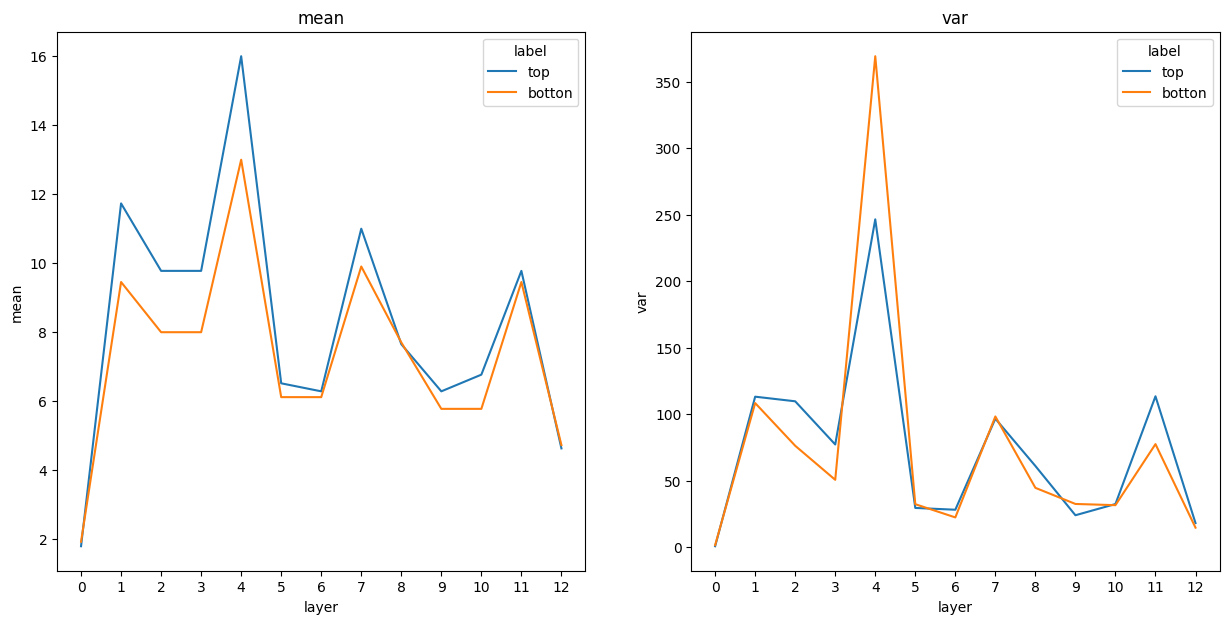

In [15]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(7)
fig.set_figwidth(15)

# sns.lineplot(data=df_layers, x='layer', y='count', hue='label', ax=ax1).set(title='count')
# sns.lineplot(data=df_layers, x='layer', y='mean', hue='label', ax=ax2).set(title='mean')
# sns.lineplot(data=df_layers, x='layer', y='var', hue='label', ax=ax3).set(title='var')
# sns.lineplot(data=df_layers, x='layer', y='sum', hue='label', ax=ax4).set(title='sum')

sns.lineplot(data=df_layers, x='layer', y='mean', hue='label', ax=ax1).set(title='mean')
sns.lineplot(data=df_layers, x='layer', y='var', hue='label', ax=ax2).set(title='var')

# mean_fstat, mean_pvalue =  stats.ttest_ind(
#     df_layers[df_layers['label'] == 'top']['mean'],
#     df_layers[df_layers['label'] == 'botton']['mean']
# )
# var_fstat, var_pvalue =  stats.ttest_ind(
#     df_layers[df_layers['label'] == 'top']['var'],
#     df_layers[df_layers['label'] == 'botton']['var']
# )

# print("      F-stat      Pvalue")
# print("Mean:   {:.2f}      {:.2f}".format(mean_fstat, mean_pvalue))
# print("var:    {:.2f}      {:.2f}".format(var_fstat, var_pvalue))

plt.savefig('images/analysis/layer_wise_' + model_ckpt.split('/')[1] + exp + '.png')

In [16]:
# df_graph_analysis = pd.DataFrame(columns=['label', 'mean_connectivity', 'assortativity', 'density'])

# df_graph_analysis = pd.concat([pd.DataFrame([[
#         'top',
#         # nx.average_clustering(G_top),
#         nx.average_node_connectivity(G_top),
#         nx.degree_assortativity_coefficient(G_top),
#         nx.density(G_top),
#     ]], columns=df_graph_analysis.columns), df_graph_analysis], ignore_index=True)

# df_graph_analysis = pd.concat([pd.DataFrame([[
#         'botton',
#         # nx.average_clustering(G_botton),
#         nx.average_node_connectivity(G_botton),
#         nx.degree_assortativity_coefficient(G_botton),
#         nx.density(G_botton),
#     ]], columns=df_graph_analysis.columns), df_graph_analysis], ignore_index=True)


# pd.plotting.parallel_coordinates(
#     df_graph_analysis,
#     'label'
# )

In [17]:
camadas = []

for x in range(model_layers_size + 1):
    camadas.append(str(x))
        
center_of_mass = 0
for i in camadas:
    center_of_mass += ((pd.Series([k for k, v in dict(G_top.nodes()).items() if k.split("_")[0] == i]).count()) * (int(i) - (model_layers_size / 2)))
print("Centro de massa top (nós):", center_of_mass / len(list(G_top.nodes())))
        
center_of_mass = 0
for i in camadas:
    center_of_mass += ((pd.Series([k for k, v in dict(G_botton.nodes()).items() if k.split("_")[0] == i]).count()) * (int(i) - (model_layers_size / 2)))
print("Centro de massa botton (nós):", center_of_mass / len(list(G_botton.nodes())))

# [x for x in range(model_layers_size)]
# [x for x in camadas]
# len(camadas)
# pd.Series([v['weight'] for k, v in dict(G_top.edges()).items()]).sum()

# pd.Series([v['weight'] for k, v in dict(G_top.edges()).items() if (k[0].split("_")[0] == i and  k[1].split("_")[0] == i+1)]).sum()
# [k for k, v in dict(G_top.edges()).items()]

camadas = []

for x in range(model_layers_size):
    camadas.append(str(x))
        
center_of_edge = 0
top_edges_by_layer = []
botton_edges_by_layer = []
for i in camadas:
    center_of_edge += ((pd.Series([v['weight'] for k, v in dict(G_top.edges()).items() if (k[0].split("_")[0] == i and  k[1].split("_")[0] == str(int(i)+1))]).sum()) * (int(i) - (model_layers_size / 2)))
    top_edges_by_layer.append(pd.Series([v['weight'] for k, v in dict(G_top.edges()).items() if (k[0].split("_")[0] == i and  k[1].split("_")[0] == str(int(i)+1))]).sum())
    # print(i, center_of_edge, pd.Series([v['weight'] for k, v in dict(G_top.edges()).items() if (k[0].split("_")[0] == i and  k[1].split("_")[0] == str(int(i)+1))]).sum())
print("Centro de massa top (arestas):", center_of_edge / len(list(G_top.edges())))
center_of_edge = 0
for i in camadas:
    center_of_edge += ((pd.Series([v['weight'] for k, v in dict(G_botton.edges()).items() if (k[0].split("_")[0] == i and  k[1].split("_")[0] == str(int(i)+1))]).sum()) * (int(i) - (model_layers_size / 2)))
    botton_edges_by_layer.append(pd.Series([v['weight'] for k, v in dict(G_botton.edges()).items() if (k[0].split("_")[0] == i and  k[1].split("_")[0] == str(int(i)+1))]).sum())
    # print(center_of_edge)
print("Centro de massa botton (arestas):", center_of_edge / len(list(G_botton.edges())))

Centro de massa top (nós): -0.30405405405405406
Centro de massa botton (nós): -0.300531914893617
Centro de massa top (arestas): -0.16523235800344235
Centro de massa botton (arestas): -0.19574468085106383


## Centralidade de auto vetor

In [18]:
len(nx.intersection(G_top, G_botton).nodes())

len(G_composed.nodes())

# fig, (ax1) = plt.subplots(1)

# fig.set_figheight(7)
# fig.set_figwidth(15)

# sns.lineplot(data=df_layers, x='layer', y='mean', ax=ax1)
# sns.lineplot(data=top_edges_by_layer, ax=ax1)
# sns.lineplot(data=botton_edges_by_layer, ax=ax1)

# i='0'
# pd.Series([v['weight'] for k, v in dict(G_top.edges()).items() if (k[0].split("_")[0] == i and  k[1].split("_")[0] == str(int(i)+1))]).sum()


# df_eigen_centrality_top = pd.DataFrame(columns=['label','layer','value'])
# df_eigen_centrality_botton = pd.DataFrame(columns=['label','layer','value'])
# camadas = []
# for x in range(model_layers_size + 1):
#     camadas.append(str(x))
# for i in camadas:
#     df_eigen_centrality_top[i] = pd.Series([v for k, v in nx.eigenvector_centrality(G_top).items() if k.split("_")[0] == i])
#     df_eigen_centrality_botton[i] = pd.Series([v for k, v in nx.eigenvector_centrality(G_botton).items() if k.split("_")[0] == i])

# for k,v in nx.eigenvector_centrality(G_top).items():
#     layer = k.split("_")[0]
#     df_eigen_centrality_top = pd.concat([df_eigen_centrality_top, pd.DataFrame([[
#         'top',
#         layer,
#         v
#     ]], columns=df_eigen_centrality_top.columns)], ignore_index=True)
    
# for k,v in nx.eigenvector_centrality(G_botton).items():
#     layer = k.split("_")[0]
#     df_eigen_centrality_botton = pd.concat([df_eigen_centrality_botton, pd.DataFrame([[
#         'botton',
#         layer,
#         v
#     ]], columns=df_eigen_centrality_botton.columns)], ignore_index=True)

# df_eigen_centrality_top = df_eigen_centrality_top.transpose().reset_index().rename(columns={'index': 'layer'}).join(pd.Series(['top'], name="label"), how="cross")
# df_eigen_centrality_botton = df_eigen_centrality_botton.transpose().reset_index().rename(columns={'index': 'layer'}).join(pd.Series(['botton'], name="label"), how="cross")


479

In [19]:
# sns.boxplot(
#     data = pd.concat([df_eigen_centrality_top, df_eigen_centrality_botton]).reset_index(drop=True),
#     x="layer",
#     y="value",
#     hue="label",
#     fill=False
# ).set(title="Distribuição de centralidade de autovetor por camada")

# plt.savefig('images/analysis/distribution_by_layer_' + model_ckpt.split('/')[1] + exp + '.png')

In [20]:
# sns.displot(
#     data = pd.concat(
#         [pd.DataFrame(pd.Series([v for k,v in nx.eigenvector_centrality(G_top).items()]), columns=["value"]).join(
#             pd.DataFrame(["top"], columns=["label"]),
#             how="cross"
#         ),
#         pd.DataFrame(pd.Series([v for k,v in nx.eigenvector_centrality(G_botton).items()]), columns=["value"]).join(
#             pd.DataFrame(["botton"], columns=["label"]),
#             how="cross"
#         )]
#     ).reset_index(drop=True),
#     hue="label",
#     x="value"
# ).set(title="Distribuição de centralidade de autovetor")
# # plt.savefig('images/analysis/distribution_' + model_ckpt.split('/')[1] + exp + '.png')

## Obtendo regiões de ativação

In [21]:
# GERANDO DF COM REGIÕES DE ATIVAÇÃO

df_model = pd.DataFrame(llm_mri.reduced_dataset[0]['label'])

cell_numeration = {}

for idx, data in enumerate(llm_mri.reduced_dataset):
    df_mid = data[['label','cell_label']].pivot_table(index=data.index, columns="cell_label")
    df_mid.columns = df_mid.columns.droplevel(0)

    cell_numeration[idx] = [df_model.columns.size, df_model.columns.size + df_mid.columns.size]
    
    df_model = pd.concat([
        df_model,
        df_mid
    ], axis=1)


df_model.iloc[:,1:] = df_model.iloc[:,1:].notnull().astype('int')

#pd.Series(df_model.iloc[:,2:].isnull().values.all(axis=0)).value_counts()
df_model

df_model = df_model[(df_model['label'] == 0) | (df_model['label'] == 2)]
df_model = df_model.replace(2, 1)
df_model

label  0_0_2  0_0_3  0_0_4  0_0_5  0_0_6  0_0_7  0_1_1  0_1_2  0_1_3  \
0        0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1        0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3        0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4        0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6        0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
418      0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
425      0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
428      1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
430      0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
434      1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

     ...  12_8_6  12_8_7  12_8_8  12_8_9  12_9_4  12_9_5  12_9_6  12_9_7  \
0    ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1    ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3    ...     0.0     0.0     1.0     0.0     0.0     0.0     0.0     0.0   
4    ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0   
6    ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
..   ...     ...     ...     ...     ...     ...     ...     ...     ...   
418  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
425  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
428  ...     0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
430  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
434  ...     0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0   

     12_9_8  12_9_9  
0       0.0     0.0  
1       0.0     0.0  
3       0.0     0.0  
4       0.0     0.0  
6       0.0     0.0  
..      ...     ...  
418     0.0     0.0  
425     0.0     0.0  
428     0.0     0.0  
430     0.0     1.0  
434     0.0     0.0  

[192 rows x 539 columns]

## Ganho de informação

Por camada e centro da rede

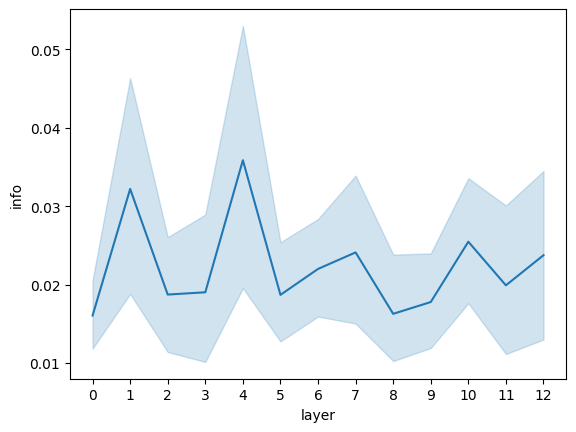

In [22]:
# COMPUTANDO GANHO DE INFORMAÇÃO POR REGIÃO

df_info_gain = pd.DataFrame()
df_info_gain["cell"] = pd.Series(list(df_model.iloc[:,1:].columns))
df_info_gain["layer"]= df_info_gain["cell"].apply(lambda x: x.split("_")[0])
df_info_gain["info"] = pd.Series(mutual_info_classif(df_model.iloc[:,1:], df_model["label"]))

sns.lineplot(
    data=df_info_gain,
    x="layer", y="info",
    # estimator="sum",
    # errorbar="sd"
)
plt.savefig('images/analysis/information_gain_layer_' + model_ckpt.split('/')[1] + exp + '.png')

# df_info_gain

In [23]:
camadas = []
for x in range(model_layers_size + 1):
    camadas.append(str(x))
center_of_info = 0
for i in camadas:
    center_of_info += ((pd.Series([row["info"] for index, row in df_info_gain.iterrows() if row["cell"].split("_")[0] == i]).mean()) * (int(i) - (model_layers_size / 2)))
print("centro de ganho de informação:", center_of_info)# / len(df_info_gain))


centro de ganho de informação: -0.025836075404372827


## Probe por camada

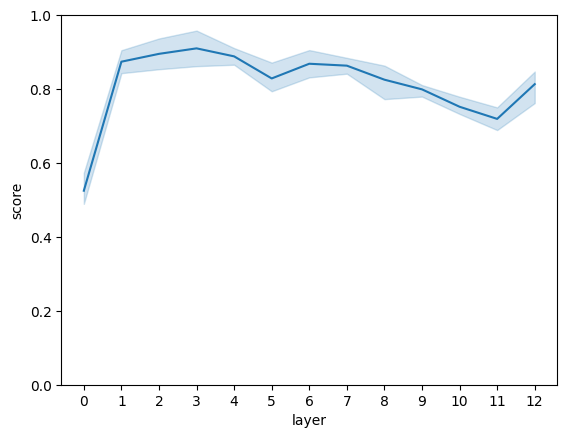

In [24]:
test_prop = 0.25
random = 42
components = 5

camadas = []
df_probe = pd.DataFrame(columns=["first", "second", "third", "fourth"])
df_probe = pd.DataFrame(columns=["layer", "score"])
for x in range(model_layers_size + 1):
    camadas.append(str(x))
for i in camadas:
    columns_of_layer = []
    for c in list(df_model.columns):
        if c.split("_")[0] == i:
            columns_of_layer.append(c)

    # pca = PCA(n_components=components)
    # logit_c_scores = cross_val_score(LogisticRegression(), pca.fit_transform(shuffle(df_model[columns_of_layer], random_state = random)), shuffle(df_model['label'], random_state = random), cv=4, scoring='f1_macro')
    logit_c_scores = cross_val_score(LogisticRegression(), shuffle(df_model[columns_of_layer], random_state = random), shuffle(df_model['label'], random_state = random), cv=4, scoring='f1_macro')
    # df_probe.loc[len(df_probe)] = logit_c_scores
    df_probe = pd.concat([
        df_probe,
        pd.concat([pd.Series(logit_c_scores, name="score"), pd.Series([1,2,3,4], name="round")],axis=1).join(pd.DataFrame([i],columns=["layer"]),how="cross")
    ])
    
sns.lineplot(data=df_probe, x="layer",y="score")
plt.ylim(0, 1)
plt.savefig('images/analysis/probes_layer_' + model_ckpt.split('/')[1] + exp + '.png')

# Analisando Projeção do Grafo

In [25]:
nodes_even_layers = set()
nodes_odd_layers = set()

camadas = []

for x in range(model_layers_size):
    camadas.append(x)

for c in camadas:
    if c % 2 == 0:
        nodes_even_layers = nodes_even_layers.union({ n for n, d in G_top.nodes(data=True) if d['layer'] == c})
    else:
        nodes_odd_layers = nodes_odd_layers.union({ n for n, d in G_top.nodes(data=True) if d['layer'] == c})


projection_even_layers_top = bipartite.collaboration_weighted_projected_graph(G_top, nodes_even_layers)
projection_odd_layers_top = bipartite.collaboration_weighted_projected_graph(G_top, nodes_odd_layers)

print("Projeção de camadas: Par - Ímpar")
print("Número de nós:", len(projection_even_layers_top.nodes()), '-', len(projection_odd_layers_top.nodes()))
print("Número de arestas:", len(projection_even_layers_top.edges()), '-',len(projection_odd_layers_top.edges()))

nodes_even_layers = set()
nodes_odd_layers = set()

for c in camadas:
    if c % 2 == 0:
        nodes_even_layers = nodes_even_layers.union({ n for n, d in G_botton.nodes(data=True) if d['layer'] == c})
    else:
        nodes_odd_layers = nodes_odd_layers.union({ n for n, d in G_botton.nodes(data=True) if d['layer'] == c})


projection_even_layers_botton = bipartite.collaboration_weighted_projected_graph(G_botton, nodes_even_layers)
projection_odd_layers_botton = bipartite.collaboration_weighted_projected_graph(G_botton, nodes_odd_layers)

print("Projeção de camadas: Par - Ímpar")
print("Número de nós:", len(projection_even_layers_botton.nodes()), '-', len(projection_odd_layers_botton.nodes()))
print("Número de arestas:", len(projection_even_layers_botton.edges()), '-',len(projection_odd_layers_botton.edges()))


Projeção de camadas: Par - Ímpar
Número de nós: 174 - 122
Número de arestas: 1275 - 895
Projeção de camadas: Par - Ímpar
Número de nós: 215 - 161
Número de arestas: 1440 - 1116


In [26]:
projection_even_layers_top.edges(data=True)

print("                        Bom    - Ruim")
print("Média par:              {:.2f} - {:.2f}".format(
      pd.Series([v for k, v in dict(nx.degree(projection_even_layers_top)).items()]).mean(),
      pd.Series([v for k, v in dict(nx.degree(projection_even_layers_botton)).items()]).mean()))
print("Média impar:            {:.2f} - {:.2f}".format(
      pd.Series([v for k, v in dict(nx.degree(projection_odd_layers_top)).items()]).mean(),
      pd.Series([v for k, v in dict(nx.degree(projection_odd_layers_botton)).items()]).mean()))

print("Var par:                {:.2f} - {:.2f}".format(
      pd.Series([v for k, v in dict(nx.degree(projection_even_layers_top)).items()]).var(),
      pd.Series([v for k, v in dict(nx.degree(projection_even_layers_botton)).items()]).var()))
print("Var impar:              {:.2f} - {:.2f}".format(
      pd.Series([v for k, v in dict(nx.degree(projection_odd_layers_top)).items()]).var(),
      pd.Series([v for k, v in dict(nx.degree(projection_odd_layers_botton)).items()]).var()))

print("Clustering par:         {:.2f} - {:.2f}".format(
      nx.average_clustering(projection_even_layers_top, weight="weight"),
      nx.average_clustering(projection_even_layers_botton, weight="weight")))
print("Clustering impar:       {:.2f} - {:.2f}".format(
      nx.average_clustering(projection_odd_layers_top, weight="weight"),
      nx.average_clustering(projection_odd_layers_botton, weight="weight")))

print("Assortatividade par:    {:.2f} - {:.2f}".format(
      nx.degree_assortativity_coefficient(projection_even_layers_top, weight="weight"),
      nx.degree_assortativity_coefficient(projection_even_layers_botton, weight="weight")))
print("Assortatividade impar:  {:.2f} - {:.2f}".format(
      nx.degree_assortativity_coefficient(projection_odd_layers_top, weight="weight"),
      nx.degree_assortativity_coefficient(projection_odd_layers_botton, weight="weight")))

print("Densidade par:          {:.2f} - {:.2f}".format(
      nx.density(projection_even_layers_top),
      nx.density(projection_even_layers_botton)))
print("Densidade impar:        {:.2f} - {:.2f}".format(
      nx.density(projection_odd_layers_top),
      nx.density(projection_odd_layers_botton)))

print("Curto par:              {:.2f} - {:.2f}".format(
      nx.average_shortest_path_length(projection_even_layers_top, weight="weight"),
      nx.average_shortest_path_length(projection_even_layers_botton, weight="weight")))
print("Curto impar:            {:.2f} - {:.2f}".format(
      nx.average_shortest_path_length(projection_odd_layers_top, weight="weight"),
      nx.average_shortest_path_length(projection_odd_layers_botton, weight="weight")))


                        Bom    - Ruim
Média par:              14.66 - 13.40
Média impar:            14.67 - 13.86
Var par:                94.77 - 94.59
Var impar:              108.78 - 99.26
Clustering par:         0.06 - 0.05
Clustering impar:       0.07 - 0.05
Assortatividade par:    0.15 - 0.18
Assortatividade impar:  0.02 - 0.03
Densidade par:          0.08 - 0.06
Densidade impar:        0.12 - 0.09
Curto par:              0.65 - 0.80
Curto impar:            0.67 - 0.76


In [27]:
print("Projeção de camadas pares    Bom  - Ruim")
print("Média de grau                {:.2f} - {:.2f}".format(pd.Series([v for k, v in dict(nx.degree(projection_even_layers_top)).items()]).mean(), pd.Series([v for k, v in dict(nx.degree(projection_even_layers_botton)).items()]).mean()))
print("Variância de grau            {:.2f} - {:.2f}".format(pd.Series([v for k, v in dict(nx.degree(projection_even_layers_top)).items()]).var(), pd.Series([v for k, v in dict(nx.degree(projection_even_layers_botton)).items()]).var()))
print("Clustering médio do grafo    {:.2f} - {:.2f}".format(nx.average_clustering(projection_even_layers_top), nx.average_clustering(projection_even_layers_botton)))
print("Assortatividade              {:.2f} - {:.2f}".format(nx.degree_assortativity_coefficient(projection_even_layers_top), nx.degree_assortativity_coefficient(projection_even_layers_botton)))
#print("Média de conectividade de nós:", nx.average_node_connectivity(projection_even_layers_top), " - ", nx.average_node_connectivity(projection_even_layers_botton))
#print("Coeficiente de Correlação de Grau     {:.2f} - {:.2f}".format(nx.degree_pearson_correlation_coefficient(projection_even_layers_top), nx.degree_pearson_correlation_coefficient(projection_even_layers_botton)))
print("Densidade                    {:.2f} - {:.2f}".format(nx.density(projection_even_layers_top), nx.density(projection_even_layers_botton)))
print("-----------------------------------------")
print("Projeção de camadas ímpares  Bom  - Ruim")
print("Média de grau                {:.2f} - {:.2f}".format(pd.Series([v for k, v in dict(nx.degree(projection_odd_layers_top)).items()]).mean(), pd.Series([v for k, v in dict(nx.degree(projection_odd_layers_botton)).items()]).mean()))
print("Variância de grau            {:.2f} - {:.2f}".format(pd.Series([v for k, v in dict(nx.degree(projection_odd_layers_top)).items()]).var(), pd.Series([v for k, v in dict(nx.degree(projection_odd_layers_botton)).items()]).var()))
print("Clustering médio do grafo    {:.2f} - {:.2f}".format(nx.average_clustering(projection_odd_layers_top), nx.average_clustering(projection_odd_layers_botton)))
print("Assortatividade              {:.2f} - {:.2f}".format(nx.degree_assortativity_coefficient(projection_odd_layers_top), nx.degree_assortativity_coefficient(projection_odd_layers_botton)))
#print("Média de conectividade de nós:", nx.average_node_connectivity(projection_odd_layers_top), " - ", nx.average_node_connectivity(projection_odd_layers_botton))
#print("Coeficiente de Correlação de Grau     {:.2f} - {:.2f}".format(nx.degree_pearson_correlation_coefficient(projection_odd_layers_top), nx.degree_pearson_correlation_coefficient(projection_odd_layers_botton)))
print("Densidade                    {:.2f} - {:.2f}".format(nx.density(projection_odd_layers_top), nx.density(projection_odd_layers_botton)))

Projeção de camadas pares    Bom  - Ruim
Média de grau                14.66 - 13.40
Variância de grau            94.77 - 94.59
Clustering médio do grafo    0.62 - 0.55
Assortatividade              0.23 - 0.29
Densidade                    0.08 - 0.06
-----------------------------------------
Projeção de camadas ímpares  Bom  - Ruim
Média de grau                14.67 - 13.86
Variância de grau            108.78 - 99.26
Clustering médio do grafo    0.59 - 0.49
Assortatividade              0.32 - 0.35
Densidade                    0.12 - 0.09


## Comparações

layer   label  clustering  assortativity   density
0   odd  botton    0.492987       0.349222  0.086646
1   odd     top    0.589454       0.315395  0.121257
2  even  botton    0.545042       0.287431  0.062595
3  even     top    0.620075       0.229877  0.084712

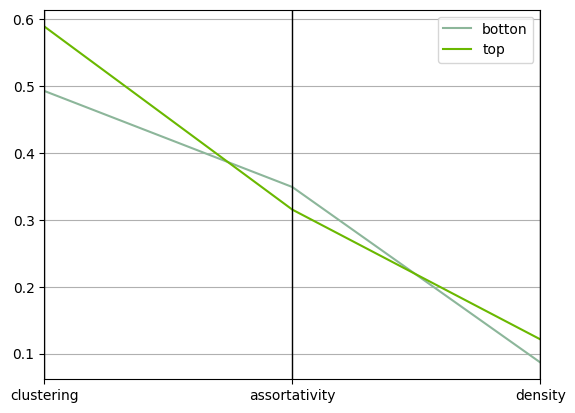

In [28]:
# df_projection_analysis = pd.DataFrame(columns=['layer', 'label', 'clustering', 'mean_connectivity', 'assortativity', 'density'])
df_projection_analysis = pd.DataFrame(columns=['layer', 'label', 'clustering', 'assortativity', 'density'])

df_projection_analysis = pd.concat([pd.DataFrame([[
        'even',
        'top',
        nx.average_clustering(projection_even_layers_top),
        # nx.average_node_connectivity(projection_even_layers_top),
        nx.degree_assortativity_coefficient(projection_even_layers_top),
        nx.density(projection_even_layers_top),
    ]], columns=df_projection_analysis.columns), df_projection_analysis], ignore_index=True)

df_projection_analysis = pd.concat([pd.DataFrame([[
        'even',
        'botton',
        nx.average_clustering(projection_even_layers_botton),
        # nx.average_node_connectivity(projection_even_layers_botton),
        nx.degree_assortativity_coefficient(projection_even_layers_botton),
        nx.density(projection_even_layers_botton),
    ]], columns=df_projection_analysis.columns), df_projection_analysis], ignore_index=True)

df_projection_analysis = pd.concat([pd.DataFrame([[
        'odd',
        'top',
        nx.average_clustering(projection_odd_layers_top),
        # nx.average_node_connectivity(projection_odd_layers_top),
        nx.degree_assortativity_coefficient(projection_odd_layers_top),
        nx.density(projection_odd_layers_top),
    ]], columns=df_projection_analysis.columns), df_projection_analysis], ignore_index=True)

df_projection_analysis = pd.concat([pd.DataFrame([[
        'odd',
        'botton',
        nx.average_clustering(projection_odd_layers_botton),
        # nx.average_node_connectivity(projection_odd_layers_botton),
        nx.degree_assortativity_coefficient(projection_odd_layers_botton),
        nx.density(projection_odd_layers_botton),
    ]], columns=df_projection_analysis.columns), df_projection_analysis], ignore_index=True)

pd.plotting.parallel_coordinates(
    df_projection_analysis[df_projection_analysis['layer'] == 'odd'].iloc[:,1:],
    'label'
)

# pd.plotting.parallel_coordinates(
#     ((df_projection_analysis[df_projection_analysis['layer'] == 'odd'].iloc[:,1:] - df_projection_analysis[df_projection_analysis['layer'] == 'odd'].iloc[:,1:].min())
#     / (df_projection_analysis[df_projection_analysis['layer'] == 'odd'].iloc[:,1:].max() - df_projection_analysis[df_projection_analysis['layer'] == 'odd'].iloc[:,1:].min()) ),
#     'label'
# )

df_projection_analysis

      F-stat      Pvalue
Mean:   0.18      0.86


<Axes: >

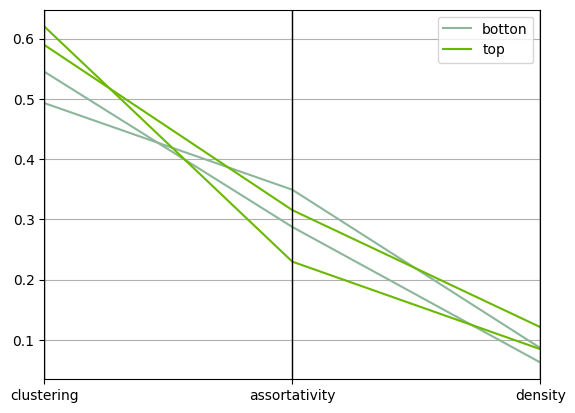

In [29]:

# list(chain.from_iterable(df_projection_analysis.loc[(
#     (df_projection_analysis['layer'] == 'odd') &
#     (df_projection_analysis['label'] == 'top')
# )].iloc[:,2:].values.tolist()))

proj_fstat, proj_pvalue =  stats.ttest_ind(
    list(chain.from_iterable(df_projection_analysis.loc[(
    (df_projection_analysis['label'] == 'top')
)].iloc[:,2:].values.tolist())),
    list(chain.from_iterable(df_projection_analysis.loc[(
    (df_projection_analysis['label'] == 'botton')
)].iloc[:,2:].values.tolist())))

print("      F-stat      Pvalue")
print("Mean:   {:.2f}      {:.2f}".format(proj_fstat, proj_pvalue))

# pd.plotting.parallel_coordinates(
#     df_projection_analysis.iloc[:,1:],
#     'label'
# )

pd.plotting.parallel_coordinates(
    df_projection_analysis.iloc[:,1:],
    'label'
)

#plt.plot(data=df_projection_analysis, x='layer', y='signal', hue='label')
#sns.lineplot(data=df_projection_analysis, x='layer', hue='label')
# sns.lineplot(data=df_layers, x='layer', y='mean', hue='label', ax=ax1)
# sns.lineplot(data=df_layers, x='layer', y='var', hue='label', ax=ax2)

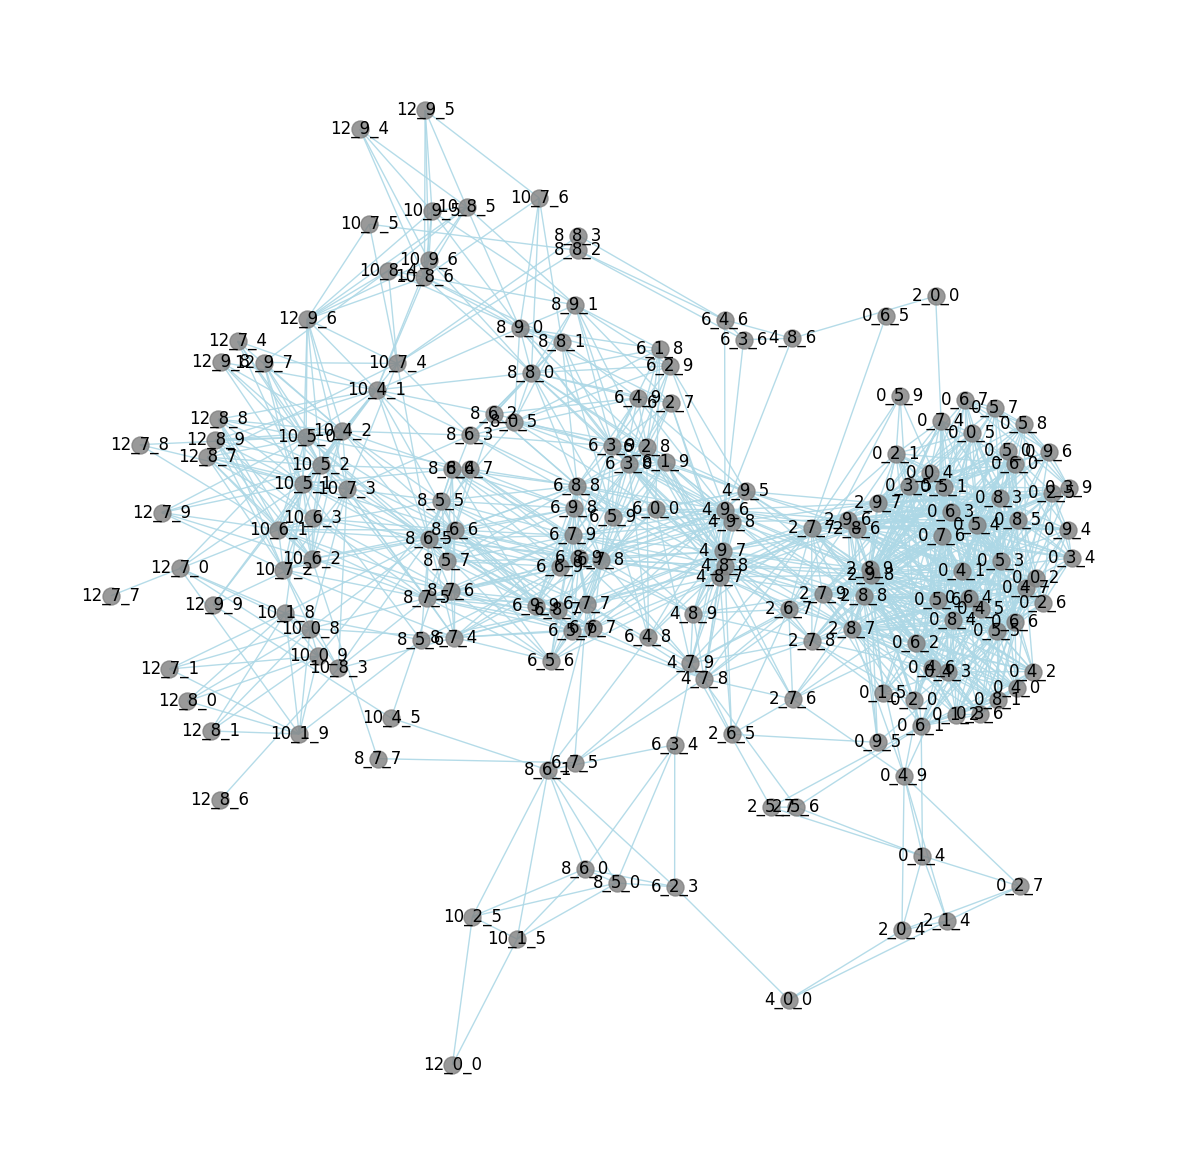

In [30]:
#display the graph
#widths = nx.get_edge_attributes(projection_even_layers, 'weight')
nodelist = projection_even_layers_top.nodes()

pos = graphviz_layout(projection_even_layers_top, prog="neato")
#make larger figure
plt.figure(figsize=(15,15))


# nx.draw(g, pos, with_labels=True, node_size=2, node_color="skyblue", node_shape="o", alpha=0.9, linewidths=20)

nx.draw_networkx_nodes(projection_even_layers_top,pos,
                       nodelist=nodelist,
                       node_size=150,
                       node_color='grey',
                       alpha=0.8)

nx.draw_networkx_edges(projection_even_layers_top,pos,
                       edgelist = projection_even_layers_top.edges,
                       #edgelist = widths.keys(),
                       #width=list(widths.values()),
                       edge_color='lightblue',
                       alpha=0.9)

nx.draw_networkx_labels(projection_even_layers_top, pos=pos,
                        labels=dict(zip(nodelist,nodelist)),
                        font_color='black')

plt.box(False)
#plt.savefig('images/projected_even')
plt.show()

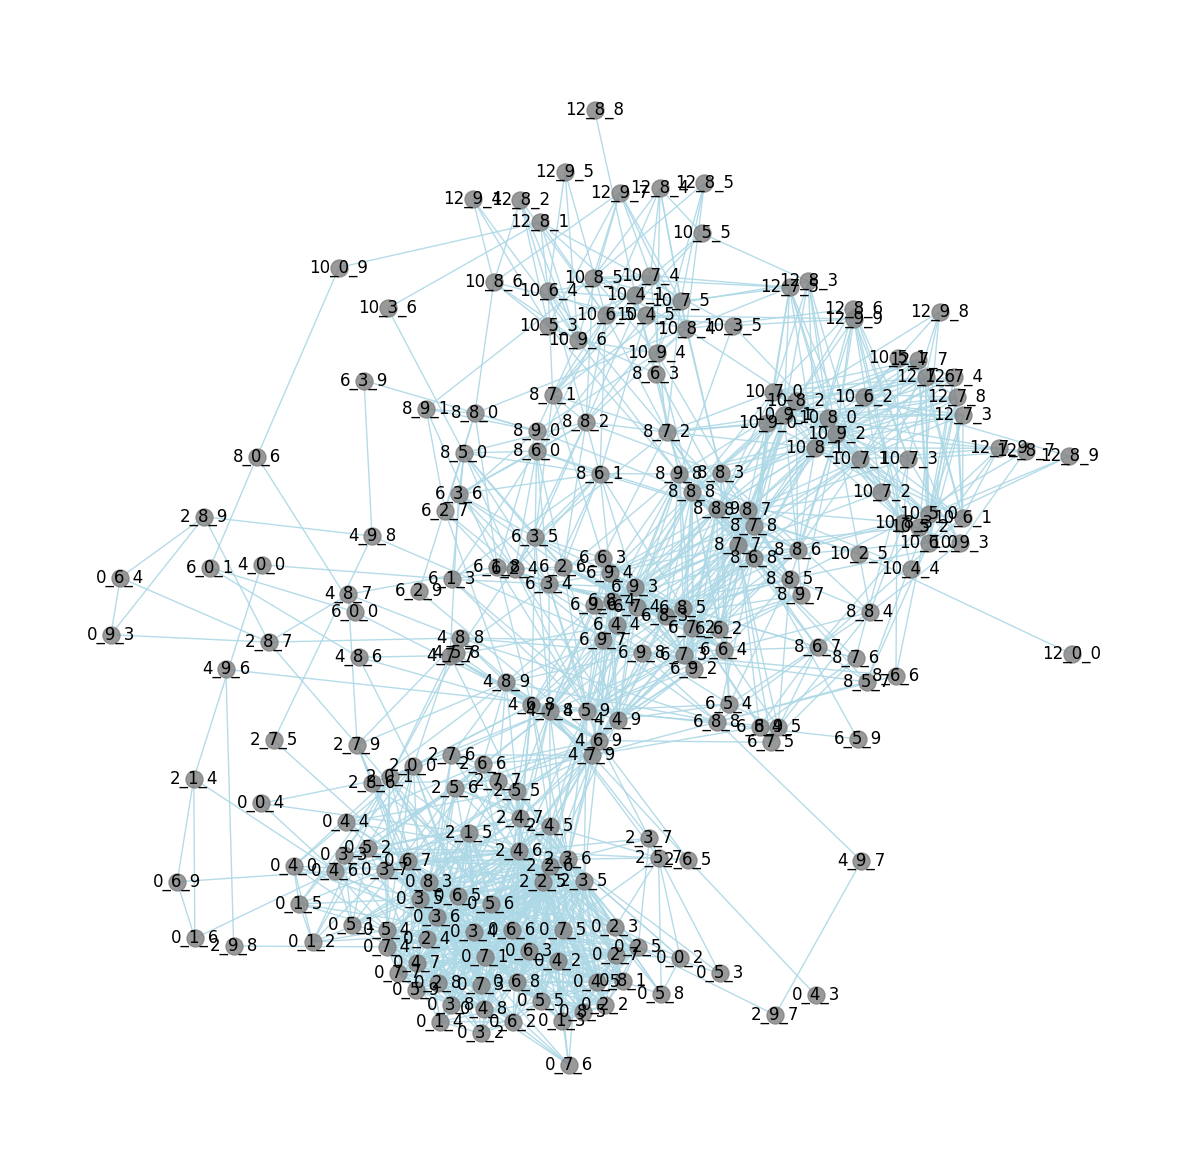

In [31]:
#display the graph
#widths = nx.get_edge_attributes(projection_even_layers, 'weight')
nodelist = projection_even_layers_botton.nodes()

pos = graphviz_layout(projection_even_layers_botton, prog="neato")
#make larger figure
plt.figure(figsize=(15,15))


# nx.draw(g, pos, with_labels=True, node_size=2, node_color="skyblue", node_shape="o", alpha=0.9, linewidths=20)

nx.draw_networkx_nodes(projection_even_layers_botton,pos,
                       nodelist=nodelist,
                       node_size=150,
                       node_color='grey',
                       alpha=0.8)

nx.draw_networkx_edges(projection_even_layers_botton,pos,
                       edgelist = projection_even_layers_botton.edges,
                       #edgelist = widths.keys(),
                       #width=list(widths.values()),
                       edge_color='lightblue',
                       alpha=0.9)

nx.draw_networkx_labels(projection_even_layers_botton, pos=pos,
                        labels=dict(zip(nodelist,nodelist)),
                        font_color='black')

plt.box(False)
#plt.savefig('images/projected_even')
plt.show()